# Import Libraries:

In [49]:
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

# Loading the Data:

In [50]:
df = pd.read_csv('data/final_data.csv')

In [51]:
df.head()

,player,team,name,position,height,age,appearance,goals,assists,yellow cards,...,goals conceded,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.000,32.000,104,0.000,0.000,0.010,...,1.217,0.335,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.000,30.000,15,0.000,0.000,0.069,...,1.242,0.207,1304,510,58,1,1500000,22000000,1,0
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.000,37.000,4,0.000,0.000,0.000,...,0.616,0.925,292,697,84,4,600000,6000000,1,0
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.000,25.000,82,0.028,0.056,0.225,...,0.000,0.000,6408,175,22,9,50000000,50000000,2,0
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.000,30.000,63,0.018,0.018,0.054,...,0.000,0.000,5031,238,51,21,40000000,80000000,2,0


# Data Preprocessing:

In [52]:
temp = df[['goals', 'assists', 'clean sheets', 'goals conceded', 'yellow cards', 'second yellow cards', 'red cards', 'minutes played']].copy()
temp.iloc[:, :-1] = temp.iloc[:, :-1].apply(lambda x: x * (temp['minutes played'] / 90))
temp.head()

,goals,assists,clean sheets,goals conceded,yellow cards,second yellow cards,red cards,minutes played
0,0.000,0.000,35.000,127.000,1.000,0.000,0.000,9390
1,0.000,0.000,3.000,18.000,1.000,0.000,0.000,1304
2,0.000,0.000,3.000,2.000,0.000,0.000,0.000,292
3,2.000,4.000,0.000,0.000,16.000,0.000,0.000,6408
4,1.000,1.000,0.000,0.000,3.000,0.000,0.000,5031


In [53]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
df.rename(columns={
    'goals': 'goals_per_90',
    'assists': 'assists_per_90',
    'clean sheets': 'clean_sheets_per_90',
    'goals conceded': 'goals_conceded_per_90',
    'yellow cards': 'yellow_cards_per_90',
    'second yellow cards': 'second_yellow_cards_per_90',
    'red cards': 'red_cards_per_90',
    'minutes played': 'minutes_played_per_90'
}, inplace=True)
df.head()

,player,team,name,position,height,age,appearance,goals_per_90,assists_per_90,yellow_cards_per_90,...,goals_conceded_per_90,clean_sheets_per_90,minutes_played_per_90,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,/david-de-gea/profil/spieler/59377,Manchester United,David de Gea,Goalkeeper,189.000,32.000,104,0.000,0.000,0.010,...,1.217,0.335,9390,42,5,13,15000000,70000000,1,0
1,/jack-butland/profil/spieler/128899,Manchester United,Jack Butland,Goalkeeper,196.000,30.000,15,0.000,0.000,0.069,...,1.242,0.207,1304,510,58,1,1500000,22000000,1,0
2,/tom-heaton/profil/spieler/34130,Manchester United,Tom Heaton,Goalkeeper,188.000,37.000,4,0.000,0.000,0.000,...,0.616,0.925,292,697,84,4,600000,6000000,1,0
3,/lisandro-martinez/profil/spieler/480762,Manchester United,Lisandro Martínez,Defender Centre-Back,175.000,25.000,82,0.028,0.056,0.225,...,0.000,0.000,6408,175,22,9,50000000,50000000,2,0
4,/raphael-varane/profil/spieler/164770,Manchester United,Raphaël Varane,Defender Centre-Back,191.000,30.000,63,0.018,0.018,0.054,...,0.000,0.000,5031,238,51,21,40000000,80000000,2,0


In [54]:
df = pd.concat([df, temp], axis=1)
df.drop(['minutes_played_per_90', 'goals_per_90', 'assists_per_90', 'clean_sheets_per_90', 'goals_conceded_per_90',
                     'goals_conceded_per_90', 'yellow_cards_per_90', 'second_yellow_cards_per_90', 'red_cards_per_90', 'winger', 
                     'minutes played', 'position_encoded' ],axis=1, inplace=True)
df = df.loc[:,~df.columns.duplicated()]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10754 entries, 0 to 10753
Data columns (total 19 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   player               10754 non-null  object 
 1   team                 10754 non-null  object 
 2   name                 10754 non-null  object 
 3   position             10754 non-null  object 
 4   height               10754 non-null  float64
 5   age                  10754 non-null  float64
 6   appearance           10754 non-null  int64  
 7   days_injured         10754 non-null  int64  
 8   games_injured        10754 non-null  int64  
 9   award                10754 non-null  int64  
 10  current_value        10754 non-null  int64  
 11  highest_value        10754 non-null  int64  
 12  goals                10754 non-null  float64
 13  assists              10754 non-null  float64
 14  clean sheets         10754 non-null  float64
 15  goals conceded       10754 non-null 

In [55]:
df['position'] = df['position'].apply(lambda x: x.split('-')[0]).apply(lambda x: x.split(' ')[0])
df['position'].unique()

array(['Goalkeeper', 'Defender', 'midfield', 'Attack'], dtype=object)

In [56]:
df.drop(['player', 'name'], axis=1, inplace=True)

In [57]:
df['team'].value_counts()

Daejeon Hana Citizen      46
Jeonbuk Hyundai Motors    46
FC Seoul                  45
Gangwon FC                43
Daegu FC                  42
                          ..
FC Barcelona              22
Atlético de Madrid        22
CA Osasuna                22
Hatayspor                 12
Gaziantep FK               6
Name: team, Length: 374, dtype: int64

In [58]:
df.shape

(10754, 17)

# Model Building:

## Feature Engineering:

In [59]:
selected_features = ['current_value', 'goals', 'assists']

In [60]:
df = df[selected_features]

In [61]:
df.shape

(10754, 3)

In [62]:
df.head()

,current_value,goals,assists
0,15000000,0.000,0.000
1,1500000,0.000,0.000
2,600000,0.000,0.000
3,50000000,2.000,4.000
4,40000000,1.000,1.000


## Data Preparation:

In [63]:
X = df

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [64]:
X.shape

(10754, 3)

# Model Building:

In [91]:
def float_formatter(y, pos):
    return f'{y:.2f}'

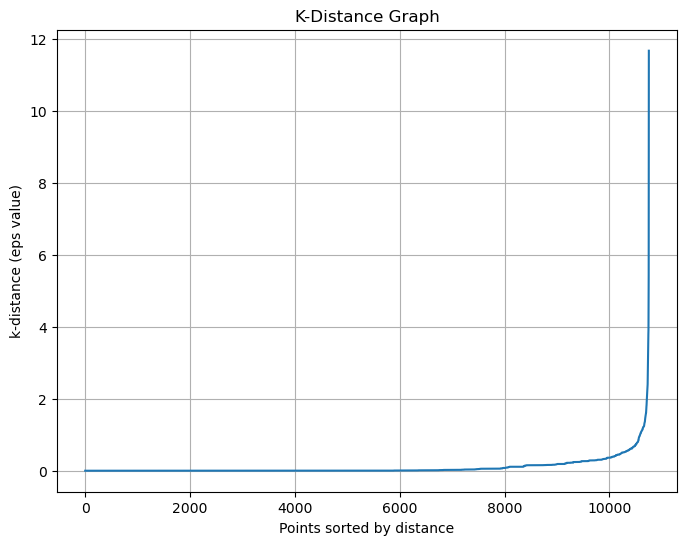

In [104]:
min_sample = 6
nn = NearestNeighbors(n_neighbors=min_sample)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

k_dist = distances[:, min_sample-1]

k_dist_sorted = np.sort(k_dist)

plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

In [109]:
chosen_eps = 0.6
model = DBSCAN(eps=chosen_eps, min_samples=min_sample)

## Model Training and Testing:

In [110]:
clusters = model.fit_predict(X_scaled)

# Model Evaluation:

In [111]:
X['dbscan'] = clusters
X['dbscan'].value_counts()

 0    10474
-1      267
 1        9
 2        4
Name: dbscan, dtype: int64

In [112]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

0.5987417316219915

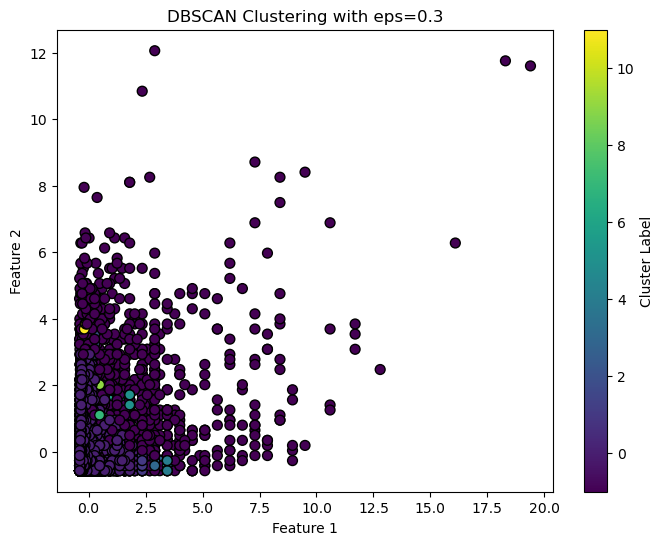

In [70]:
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

<AxesSubplot:xlabel='goals', ylabel='current_value'>

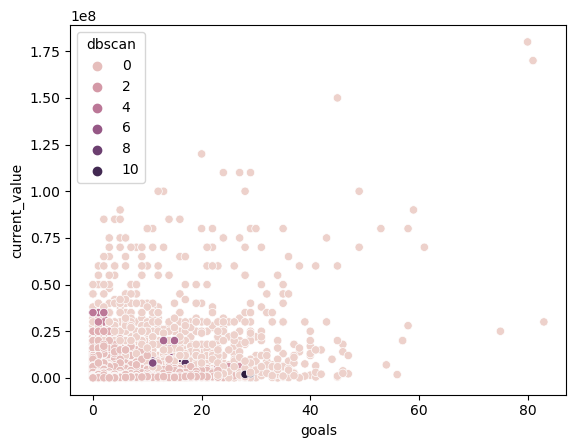

In [71]:
sns.scatterplot(data = X , x = 'goals', y = 'current_value', hue = 'dbscan')

<AxesSubplot:xlabel='current_value', ylabel='assists'>

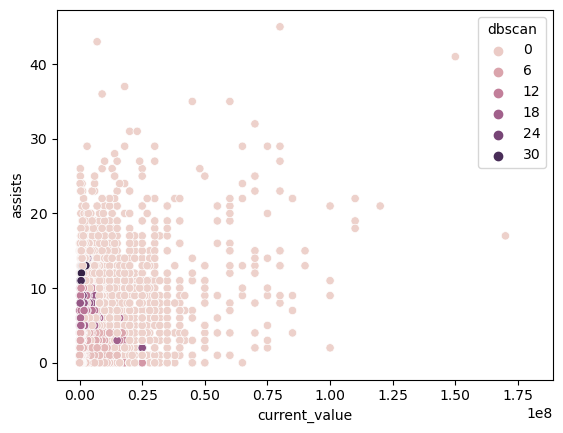

In [77]:
sns.scatterplot(data = X , x = 'current_value', y = 'assists', hue = 'dbscan')